# Demo #3: Hybrid Search (Dense + Sparse Retrieval)

## Learning Objectives

In this demonstration, you will learn:

1. **Dense vs Sparse Retrieval**: Understanding the fundamental differences and strengths of each approach
2. **BM25 Algorithm**: How traditional keyword-based search works and when it excels
3. **Hybrid Search**: Combining semantic and lexical search for robust retrieval
4. **Weighted Fusion**: Balancing dense and sparse retrieval with alpha parameters

## Theoretical Background

### The Two Paradigms of Search

Information retrieval has evolved through two major paradigms:

#### 1. Sparse Retrieval (Lexical/Keyword-Based)

**Examples**: TF-IDF, BM25  
**Principle**: Represents documents as sparse vectors based on word frequencies  
**Strengths**:
- Excellent for exact keyword matches
- Works well with acronyms, product codes, specific jargon
- Computationally efficient
- Interpretable and deterministic

**Weaknesses**:
- No semantic understanding ("car" ≠ "automobile")
- Vocabulary mismatch problem
- Cannot handle synonyms or paraphrasing

#### 2. Dense Retrieval (Semantic/Vector-Based)

**Examples**: Sentence transformers, embedding models  
**Principle**: Represents documents as dense vectors in a continuous semantic space  
**Strengths**:
- Captures semantic meaning and context
- Handles synonyms, paraphrasing, conceptual similarity
- Can find relevant documents with completely different wording

**Weaknesses**:
- Can miss exact keyword matches
- Less reliable for specific technical terms or acronyms
- Embedding quality depends on training data

### Hybrid Search: Best of Both Worlds

Hybrid search combines both approaches, recognizing that:
- Some queries require exact matching ("What is the GPT-4 API endpoint?")
- Others require semantic understanding ("How do transformers process sequences?")
- Most queries benefit from both

**Fusion Strategy**:
```
hybrid_score = α × dense_score + (1 - α) × sparse_score
```
Where α ∈ [0, 1] controls the balance (α=0.5 means equal weight)

**Key Citations**:
- RAG Series III: Hybrid Search (Reference 24)
- Improving RAG Performance: WTF is Hybrid Search? - Fuzzy Labs (Reference 25)

## 1. Environment Setup

In [1]:
# Core imports
import os
from pathlib import Path
from typing import List
import warnings
warnings.filterwarnings('ignore')

# LlamaIndex core components
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Settings,
    StorageContext
)
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.retrievers import QueryFusionRetriever

# BM25 Retriever
from llama_index.retrievers.bm25 import BM25Retriever

# Azure OpenAI components
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

# Utilities
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

print("✓ All imports successful")

✓ All imports successful


In [2]:
# Azure OpenAI Configuration
llm = AzureOpenAI(
    model="gpt-4o",
    deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4o"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-15-preview",
    temperature=0.1
)

embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT", "text-embedding-ada-002"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-15-preview"
)

# Set global settings
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = 512
Settings.chunk_overlap = 50

print("✓ Azure OpenAI configured")

✓ Azure OpenAI configured


## 2. Data Preparation

We'll load technical documents with jargon and acronyms to demonstrate BM25's strengths.

In [3]:
# Load documents from tech_docs directory (contains acronyms, technical terms)
data_path = Path("./data/tech_docs")
documents = SimpleDirectoryReader(
    input_dir=str(data_path),
    required_exts=[".md"],
    recursive=False
).load_data()

# Use first 5-6 documents
documents = documents[:6]

print(f"✓ Loaded {len(documents)} documents:")
for i, doc in enumerate(documents, 1):
    filename = Path(doc.metadata.get('file_name', 'unknown')).name
    word_count = len(doc.text.split())
    print(f"  {i}. {filename} ({word_count} words)")

✓ Loaded 6 documents:
  1. bert_model.md (312 words)
  2. docker_containers.md (637 words)
  3. embeddings_ml.md (715 words)
  4. gpt4_model.md (372 words)
  5. rest_api.md (515 words)
  6. transformer_architecture.md (556 words)


## 3. Create Nodes (Chunks)

Both dense and sparse retrievers need to work on the same chunks.

In [4]:
# Create node parser
node_parser = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=50
)

# Parse documents into nodes
nodes = node_parser.get_nodes_from_documents(documents)

print(f"✓ Created {len(nodes)} text chunks (nodes)")
print(f"  First node preview: {nodes[0].text[:150]}...")

✓ Created 15 text chunks (nodes)
  First node preview: # BERT: Bidirectional Encoder Representations from Transformers

**BERT** is a transformer-based language model developed by Google Research in 2018. ...


## 4. Dense Vector Search Implementation

First, let's implement standard semantic vector search.

In [5]:
# Build vector store index
print("Building dense vector index...")
vector_index = VectorStoreIndex(
    nodes,
    show_progress=True
)

# Create vector retriever
vector_retriever = vector_index.as_retriever(
    similarity_top_k=5
)

print("✓ Dense vector retriever ready")

Building dense vector index...


Generating embeddings:   0%|          | 0/15 [00:00<?, ?it/s]

2025-10-16 14:41:14,576 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:41:14,820 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"


✓ Dense vector retriever ready


## 5. Sparse BM25 Search Implementation

Now, let's implement BM25, the gold standard for keyword-based retrieval.

In [6]:
# Create BM25 retriever
print("Building BM25 index...")
bm25_retriever = BM25Retriever.from_defaults(
    nodes=nodes,
    similarity_top_k=5
)

print("✓ BM25 retriever ready")
print("\nℹ️  BM25 uses statistical keyword matching based on:")
print("   - Term Frequency (TF): How often a term appears in a document")
print("   - Inverse Document Frequency (IDF): How rare/common a term is across all documents")
print("   - Document length normalization")

2025-10-16 14:41:14,870 - DEBUG - Building index from IDs objects


Building BM25 index...
✓ BM25 retriever ready

ℹ️  BM25 uses statistical keyword matching based on:
   - Term Frequency (TF): How often a term appears in a document
   - Inverse Document Frequency (IDF): How rare/common a term is across all documents
   - Document length normalization


## 6. Hybrid Retriever Implementation

Combine both retrievers using QueryFusionRetriever.

In [7]:
# Create hybrid retriever that fuses vector and BM25 results
hybrid_retriever = QueryFusionRetriever(
    retrievers=[vector_retriever, bm25_retriever],
    similarity_top_k=5,
    num_queries=1,  # No query generation, just fusion
    mode="reciprocal_rerank",  # Use RRF for fusion
    use_async=False
)

print("✓ Hybrid retriever ready")
print("  Fusion method: Reciprocal Rank Fusion (RRF)")
print("  Combining: Dense vector search + BM25 sparse search")

✓ Hybrid retriever ready
  Fusion method: Reciprocal Rank Fusion (RRF)
  Combining: Dense vector search + BM25 sparse search


## 7. Comparative Testing

Let's test all three approaches with different types of queries.

In [8]:
from llama_index.core import QueryBundle

def compare_retrievers(query: str, vector_ret, bm25_ret, hybrid_ret):
    """
    Compare retrieval results from vector, BM25, and hybrid approaches.
    """
    print("\n" + "="*100)
    print(f"QUERY: {query}")
    print("="*100)
    
    query_bundle = QueryBundle(query_str=query)
    
    # Get results from each retriever
    vector_results = vector_ret.retrieve(query_bundle)
    bm25_results = bm25_ret.retrieve(query_bundle)
    hybrid_results = hybrid_ret.retrieve(query_bundle)
    
    # Helper function to extract source info
    def get_sources(results):
        return [(Path(n.node.metadata.get('file_name', 'unknown')).stem, n.score) 
                for n in results[:3]]
    
    vector_sources = get_sources(vector_results)
    bm25_sources = get_sources(bm25_results)
    hybrid_sources = get_sources(hybrid_results)
    
    # Display results
    print("\n🔵 DENSE VECTOR SEARCH (Semantic)")
    print("-" * 100)
    for i, (source, score) in enumerate(vector_sources, 1):
        print(f"  {i}. {source:<40} Score: {score:.4f}")
    
    print("\n🟠 SPARSE BM25 SEARCH (Keyword)")
    print("-" * 100)
    for i, (source, score) in enumerate(bm25_sources, 1):
        print(f"  {i}. {source:<40} Score: {score:.4f}")
    
    print("\n🟢 HYBRID SEARCH (Combined)")
    print("-" * 100)
    for i, (source, score) in enumerate(hybrid_sources, 1):
        print(f"  {i}. {source:<40} Score: {score:.4f}")
    
    # Analysis
    vector_set = set(s for s, _ in vector_sources)
    bm25_set = set(s for s, _ in bm25_sources)
    hybrid_set = set(s for s, _ in hybrid_sources)
    
    print("\n📊 ANALYSIS:")
    print("-" * 100)
    print(f"  Vector-only sources: {vector_set - bm25_set}")
    print(f"  BM25-only sources:   {bm25_set - vector_set}")
    print(f"  Common sources:      {vector_set & bm25_set}")
    print(f"  Hybrid unique pick:  {hybrid_set - (vector_set | bm25_set)}")
    
    return {
        'vector': vector_results,
        'bm25': bm25_results,
        'hybrid': hybrid_results
    }

print("✓ Comparison function ready")

✓ Comparison function ready


### 7.1 Test Query 1: Semantic/Conceptual Query

This query emphasizes concepts over exact terms.

In [9]:
query1 = "How do neural language models understand context in sequences?"

results1 = compare_retrievers(
    query1,
    vector_retriever,
    bm25_retriever,
    hybrid_retriever
)

print("\n💡 EXPECTED: Dense vector search should excel here (semantic understanding)")


QUERY: How do neural language models understand context in sequences?


2025-10-16 14:41:15,173 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



🔵 DENSE VECTOR SEARCH (Semantic)
----------------------------------------------------------------------------------------------------
  1. bert_model                               Score: 0.7738
  2. embeddings_ml                            Score: 0.7704
  3. transformer_architecture                 Score: 0.7692

🟠 SPARSE BM25 SEARCH (Keyword)
----------------------------------------------------------------------------------------------------
  1. bert_model                               Score: 2.0865
  2. transformer_architecture                 Score: 1.9988
  3. embeddings_ml                            Score: 1.7980

🟢 HYBRID SEARCH (Combined)
----------------------------------------------------------------------------------------------------
  1. bert_model                               Score: 0.0333
  2. transformer_architecture                 Score: 0.0325
  3. embeddings_ml                            Score: 0.0320

📊 ANALYSIS:
--------------------------------------------------

### 7.2 Test Query 2: Keyword/Acronym Query

This query uses specific technical terms and acronyms.

In [10]:
query2 = "What is the REST API endpoint structure?"

results2 = compare_retrievers(
    query2,
    vector_retriever,
    bm25_retriever,
    hybrid_retriever
)

print("\n💡 EXPECTED: BM25 should excel here (exact term matching: 'REST', 'API', 'endpoint')")


QUERY: What is the REST API endpoint structure?


2025-10-16 14:41:15,354 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



🔵 DENSE VECTOR SEARCH (Semantic)
----------------------------------------------------------------------------------------------------
  1. rest_api                                 Score: 0.8457
  2. rest_api                                 Score: 0.8145
  3. transformer_architecture                 Score: 0.7378

🟠 SPARSE BM25 SEARCH (Keyword)
----------------------------------------------------------------------------------------------------
  1. rest_api                                 Score: 2.2293
  2. rest_api                                 Score: 1.5953
  3. docker_containers                        Score: 1.4331

🟢 HYBRID SEARCH (Combined)
----------------------------------------------------------------------------------------------------
  1. rest_api                                 Score: 0.0333
  2. rest_api                                 Score: 0.0328
  3. docker_containers                        Score: 0.0318

📊 ANALYSIS:
--------------------------------------------------

### 7.3 Test Query 3: Mixed Query

This query requires both semantic understanding and keyword matching.

In [11]:
query3 = "Explain how BERT embeddings capture semantic meaning"

results3 = compare_retrievers(
    query3,
    vector_retriever,
    bm25_retriever,
    hybrid_retriever
)

print("\n💡 EXPECTED: Hybrid should excel here (needs both 'BERT' exact match + semantic 'embeddings', 'meaning')")


QUERY: Explain how BERT embeddings capture semantic meaning


2025-10-16 14:41:15,518 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



🔵 DENSE VECTOR SEARCH (Semantic)
----------------------------------------------------------------------------------------------------
  1. embeddings_ml                            Score: 0.8362
  2. bert_model                               Score: 0.8309
  3. embeddings_ml                            Score: 0.8149

🟠 SPARSE BM25 SEARCH (Keyword)
----------------------------------------------------------------------------------------------------
  1. embeddings_ml                            Score: 3.9285
  2. embeddings_ml                            Score: 2.5940
  3. embeddings_ml                            Score: 2.1508

🟢 HYBRID SEARCH (Combined)
----------------------------------------------------------------------------------------------------
  1. embeddings_ml                            Score: 0.0333
  2. embeddings_ml                            Score: 0.0325
  3. bert_model                               Score: 0.0323

📊 ANALYSIS:
--------------------------------------------------

## 8. Detailed Content Comparison

Let's look at what content each retriever actually retrieved.

In [12]:
def show_retrieved_content(query, results_dict, max_chars=300):
    """
    Display actual retrieved content from each retriever.
    """
    print("\n" + "#"*100)
    print(f"# CONTENT COMPARISON FOR: {query}")
    print("#"*100)
    
    for method, results in results_dict.items():
        print(f"\n{'='*100}")
        print(f"{method.upper()} - TOP RETRIEVED CHUNK")
        print(f"{'='*100}")
        
        top_node = results[0]
        source = Path(top_node.node.metadata.get('file_name', 'unknown')).stem
        
        print(f"\nSource: {source}")
        print(f"Score:  {top_node.score:.4f}")
        print(f"\nContent:")
        print("-" * 100)
        content = top_node.node.text[:max_chars]
        print(content + "..." if len(top_node.node.text) > max_chars else content)
        print("-" * 100)

# Show content for the mixed query (most interesting)
show_retrieved_content(query3, results3)


####################################################################################################
# CONTENT COMPARISON FOR: Explain how BERT embeddings capture semantic meaning
####################################################################################################

VECTOR - TOP RETRIEVED CHUNK

Source: embeddings_ml
Score:  0.8362

Content:
----------------------------------------------------------------------------------------------------
# Embeddings in Machine Learning

**Embeddings** are dense vector representations of discrete objects (words, images, users, items) that capture semantic meaning in a continuous, low-dimensional space. They are fundamental to modern machine learning, particularly in natural language processing and r...
----------------------------------------------------------------------------------------------------

BM25 - TOP RETRIEVED CHUNK

Source: embeddings_ml
Score:  3.9285

Content:
----------------------------------------------------------

## 9. Quantitative Analysis

Let's perform statistical analysis across multiple queries.

In [13]:
import pandas as pd
import numpy as np

# Test suite with different query types
test_suite = [
    ("Semantic", "How do transformers process sequential information?"),
    ("Keyword", "What is Docker containerization?"),
    ("Mixed", "Explain GPT-4 architecture for natural language"),
    ("Acronym", "What are REST API best practices?"),
    ("Conceptual", "How does machine learning understand patterns?")
]

results_data = []

for query_type, query in test_suite:
    query_bundle = QueryBundle(query_str=query)
    
    # Retrieve
    vector_res = vector_retriever.retrieve(query_bundle)
    bm25_res = bm25_retriever.retrieve(query_bundle)
    hybrid_res = hybrid_retriever.retrieve(query_bundle)
    
    # Calculate average scores
    vector_avg = np.mean([n.score for n in vector_res[:3]])
    bm25_avg = np.mean([n.score for n in bm25_res[:3]])
    hybrid_avg = np.mean([n.score for n in hybrid_res[:3]])
    
    # Count unique sources
    vector_sources = set(Path(n.node.metadata.get('file_name', 'unknown')).stem 
                        for n in vector_res[:3])
    bm25_sources = set(Path(n.node.metadata.get('file_name', 'unknown')).stem 
                      for n in bm25_res[:3])
    hybrid_sources = set(Path(n.node.metadata.get('file_name', 'unknown')).stem 
                        for n in hybrid_res[:3])
    
    results_data.append({
        'Query Type': query_type,
        'Query': query[:50] + '...' if len(query) > 50 else query,
        'Vector Avg Score': vector_avg,
        'BM25 Avg Score': bm25_avg,
        'Hybrid Avg Score': hybrid_avg,
        'Vector Diversity': len(vector_sources),
        'BM25 Diversity': len(bm25_sources),
        'Hybrid Diversity': len(hybrid_sources)
    })

# Create DataFrame
df = pd.DataFrame(results_data)

print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE ANALYSIS")
print("="*100)
print("\n", df.to_string(index=False))

# Summary statistics
print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)
print(f"\nAverage Scores Across All Queries:")
print(f"  Vector:  {df['Vector Avg Score'].mean():.4f}")
print(f"  BM25:    {df['BM25 Avg Score'].mean():.4f}")
print(f"  Hybrid:  {df['Hybrid Avg Score'].mean():.4f}")

print(f"\nAverage Diversity (Unique Sources in Top 3):")
print(f"  Vector:  {df['Vector Diversity'].mean():.2f}")
print(f"  BM25:    {df['BM25 Diversity'].mean():.2f}")
print(f"  Hybrid:  {df['Hybrid Diversity'].mean():.2f}")

2025-10-16 14:41:15,817 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:41:15,928 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:41:16,036 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:41:16,138 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:41:16,268 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



COMPREHENSIVE PERFORMANCE ANALYSIS

 Query Type                                                 Query  Vector Avg Score  BM25 Avg Score  Hybrid Avg Score  Vector Diversity  BM25 Diversity  Hybrid Diversity
  Semantic How do transformers process sequential information...          0.793768        1.578355          0.027075                 1               3                 2
   Keyword                      What is Docker containerization?          0.824122        1.465985          0.032625                 1               2                 2
     Mixed       Explain GPT-4 architecture for natural language          0.810166        1.888384          0.032793                 2               2                 2
   Acronym                     What are REST API best practices?          0.812361        2.355285          0.032539                 2               2                 2
Conceptual        How does machine learning understand patterns?          0.763988        1.863049          0.032360 

## 10. Visualization

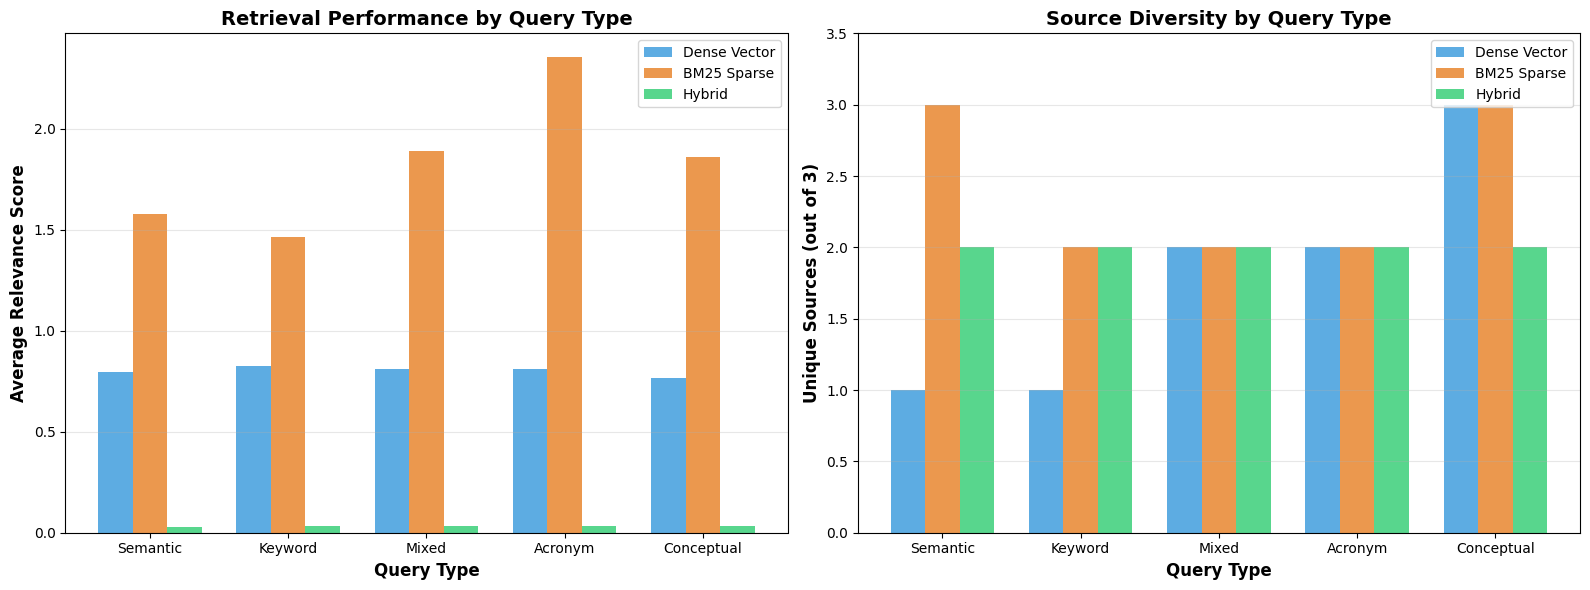


✓ Visualization saved as 'hybrid_search_comparison.png'


In [14]:
import matplotlib.pyplot as plt

# Prepare data
query_types = df['Query Type'].values
vector_scores = df['Vector Avg Score'].values
bm25_scores = df['BM25 Avg Score'].values
hybrid_scores = df['Hybrid Avg Score'].values

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Score comparison
x = np.arange(len(query_types))
width = 0.25

bars1 = ax1.bar(x - width, vector_scores, width, label='Dense Vector', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x, bm25_scores, width, label='BM25 Sparse', alpha=0.8, color='#e67e22')
bars3 = ax1.bar(x + width, hybrid_scores, width, label='Hybrid', alpha=0.8, color='#2ecc71')

ax1.set_xlabel('Query Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Relevance Score', fontsize=12, fontweight='bold')
ax1.set_title('Retrieval Performance by Query Type', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(query_types, rotation=0)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Diversity comparison
vector_div = df['Vector Diversity'].values
bm25_div = df['BM25 Diversity'].values
hybrid_div = df['Hybrid Diversity'].values

bars4 = ax2.bar(x - width, vector_div, width, label='Dense Vector', alpha=0.8, color='#3498db')
bars5 = ax2.bar(x, bm25_div, width, label='BM25 Sparse', alpha=0.8, color='#e67e22')
bars6 = ax2.bar(x + width, hybrid_div, width, label='Hybrid', alpha=0.8, color='#2ecc71')

ax2.set_xlabel('Query Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Unique Sources (out of 3)', fontsize=12, fontweight='bold')
ax2.set_title('Source Diversity by Query Type', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(query_types, rotation=0)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 3.5)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('hybrid_search_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'hybrid_search_comparison.png'")

## 11. Custom Weighted Hybrid Search

The QueryFusionRetriever uses RRF. Let's implement custom weighted fusion with an alpha parameter for more control.

In [15]:
from llama_index.core.schema import NodeWithScore
from typing import Dict

def weighted_hybrid_search(
    query: str,
    vector_retriever,
    bm25_retriever,
    alpha: float = 0.5,
    top_k: int = 5
) -> List[NodeWithScore]:
    """
    Implement custom weighted hybrid search.
    
    Args:
        query: Search query
        vector_retriever: Dense vector retriever
        bm25_retriever: Sparse BM25 retriever
        alpha: Weight for dense scores (0 = all BM25, 1 = all vector)
        top_k: Number of results to return
    
    Returns:
        Fused and reranked results
    """
    query_bundle = QueryBundle(query_str=query)
    
    # Get results
    vector_results = vector_retriever.retrieve(query_bundle)
    bm25_results = bm25_retriever.retrieve(query_bundle)
    
    # Normalize scores to [0, 1] range
    def normalize_scores(results):
        if not results:
            return {}
        scores = [r.score for r in results]
        min_score, max_score = min(scores), max(scores)
        if max_score == min_score:
            return {r.node.node_id: 1.0 for r in results}
        return {
            r.node.node_id: (r.score - min_score) / (max_score - min_score)
            for r in results
        }
    
    vector_scores_norm = normalize_scores(vector_results)
    bm25_scores_norm = normalize_scores(bm25_results)
    
    # Combine scores with weighting
    all_node_ids = set(vector_scores_norm.keys()) | set(bm25_scores_norm.keys())
    combined_scores = {}
    node_map = {}
    
    # Map nodes
    for result in vector_results + bm25_results:
        node_map[result.node.node_id] = result.node
    
    # Calculate weighted scores
    for node_id in all_node_ids:
        vector_score = vector_scores_norm.get(node_id, 0.0)
        bm25_score = bm25_scores_norm.get(node_id, 0.0)
        
        # Weighted combination
        combined_scores[node_id] = alpha * vector_score + (1 - alpha) * bm25_score
    
    # Sort and create results
    sorted_nodes = sorted(
        combined_scores.items(),
        key=lambda x: x[1],
        reverse=True
    )[:top_k]
    
    results = [
        NodeWithScore(node=node_map[node_id], score=score)
        for node_id, score in sorted_nodes
    ]
    
    return results

print("✓ Custom weighted hybrid search function defined")

✓ Custom weighted hybrid search function defined


### Test Different Alpha Values

In [16]:
test_query = "What are the components of a transformer model?"

print(f"\n{'='*100}")
print(f"TESTING ALPHA PARAMETER: {test_query}")
print(f"{'='*100}")

alphas = [0.0, 0.25, 0.5, 0.75, 1.0]

for alpha in alphas:
    results = weighted_hybrid_search(
        test_query,
        vector_retriever,
        bm25_retriever,
        alpha=alpha,
        top_k=3
    )
    
    print(f"\nα = {alpha:.2f} {'(Pure BM25)' if alpha == 0 else '(Pure Vector)' if alpha == 1 else '(Balanced)' if alpha == 0.5 else ''}")
    print("-" * 100)
    
    for i, node in enumerate(results, 1):
        source = Path(node.node.metadata.get('file_name', 'unknown')).stem
        print(f"  {i}. {source:<40} Score: {node.score:.4f}")


TESTING ALPHA PARAMETER: What are the components of a transformer model?


2025-10-16 14:41:17,659 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



α = 0.00 (Pure BM25)
----------------------------------------------------------------------------------------------------
  1. transformer_architecture                 Score: 1.0000
  2. transformer_architecture                 Score: 0.5008
  3. docker_containers                        Score: 0.3534


2025-10-16 14:41:17,772 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



α = 0.25 
----------------------------------------------------------------------------------------------------
  1. transformer_architecture                 Score: 0.9606
  2. transformer_architecture                 Score: 0.6256
  3. docker_containers                        Score: 0.2651


2025-10-16 14:41:17,889 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



α = 0.50 (Balanced)
----------------------------------------------------------------------------------------------------
  1. transformer_architecture                 Score: 0.9213
  2. transformer_architecture                 Score: 0.7504
  3. transformer_architecture                 Score: 0.2998


2025-10-16 14:41:18,002 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



α = 0.75 
----------------------------------------------------------------------------------------------------
  1. transformer_architecture                 Score: 0.8819
  2. transformer_architecture                 Score: 0.8752
  3. transformer_architecture                 Score: 0.4497


2025-10-16 14:41:18,121 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



α = 1.00 (Pure Vector)
----------------------------------------------------------------------------------------------------
  1. transformer_architecture                 Score: 1.0000
  2. transformer_architecture                 Score: 0.8426
  3. transformer_architecture                 Score: 0.5996


## Key Takeaways

### What We Learned

1. **Complementary Strengths**: Dense and sparse retrieval excel at different tasks:
   - Dense (vector): Semantic similarity, synonyms, conceptual understanding
   - Sparse (BM25): Exact terms, acronyms, rare keywords, specific jargon

2. **Hybrid is More Robust**: Combining both methods provides consistent performance across diverse query types, hedging against the weaknesses of either approach alone.

3. **No Universal Winner**: The "best" retrieval method depends on the query type and domain. Hybrid search provides insurance against edge cases.

4. **Fusion Strategies Matter**: 
   - RRF (Reciprocal Rank Fusion): Simple, no normalization needed, robust
   - Weighted fusion: Allows fine-tuning with alpha parameter for domain-specific optimization

5. **BM25 Still Relevant**: Despite the hype around embeddings, traditional BM25 remains highly effective for many retrieval tasks, especially with technical content.

### When to Use Each Approach

#### Use Dense Vector Search When:
- Queries are conceptual or semantic
- Users may use different vocabulary than documents
- Paraphrasing and synonyms are common
- Domain requires understanding context

#### Use BM25 Sparse Search When:
- Exact keyword matching is critical
- Content has many acronyms, product codes, or jargon
- Rare or unique terms are important signals
- You need fast, deterministic, interpretable results

#### Use Hybrid Search When:
- Query types are diverse and unpredictable
- You need robust performance across all scenarios
- Content mixes technical terms with natural language
- Production systems where reliability > marginal performance gains
- **Recommendation**: Use hybrid as the default for production RAG systems

### Implementation Best Practices

1. **Start with Hybrid**: Unless you have specific reasons not to, hybrid search is the safest default
2. **Tune Alpha**: For weighted fusion, start at α=0.5, then adjust based on evaluation:
   - α > 0.5: Favor semantic search (more natural language)
   - α < 0.5: Favor keyword search (more technical jargon)
3. **Normalize Scores**: When using weighted fusion, always normalize scores before combining
4. **Monitor Performance**: Track which retriever "wins" for different query types to inform tuning

### Next Steps

In the next demo, we'll explore **Hierarchical Retrieval** with sentence window techniques, which addresses a different problem: optimizing the granularity of retrieval versus generation context.